# パフォーマンスを集約

In [73]:
import pandas as pd
import glob
from scipy.stats import ttest_1samp
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fn_l = glob.glob("../data/result/*.csv")
fn_l.sort()
fn_l

['../data/result/m10_w13_b128.csv',
 '../data/result/m10_w13_b256.csv',
 '../data/result/m10_w4_b128.csv',
 '../data/result/m10_w4_b256.csv',
 '../data/result/m9_w13_b128.csv',
 '../data/result/m9_w13_b256.csv',
 '../data/result/m9_w4_b128.csv',
 '../data/result/m9_w4_b256.csv']

In [3]:
data_d = dict()
for fn_i in fn_l:
    df = pd.read_csv(fn_i, parse_dates=["date"])
    data_d.update({fn_i: df.copy()})

In [4]:
for k, v in data_d.items():
    print(k)

../data/result/m10_w13_b128.csv
../data/result/m10_w13_b256.csv
../data/result/m10_w4_b128.csv
../data/result/m10_w4_b256.csv
../data/result/m9_w13_b128.csv
../data/result/m9_w13_b256.csv
../data/result/m9_w4_b128.csv
../data/result/m9_w4_b256.csv


## training data

In [5]:
def calculate_average(data_d: dict, coln: str) -> pd.DataFrame:
    result_l = list()
    for k, v in data_d.items():
        # 全期間
        all_ = v[coln].mean()
        # last 5yr
        last5yr = v[coln].iloc[-52*5:].mean()
        # last 3yr
        last3yr = v[coln].iloc[-52*3:].mean()
        # last 1yr
        last1yr = v[coln].iloc[-52*1:].mean()
        result_l.append([k, all_, last5yr, last3yr, last1yr])

    result_df = pd.DataFrame(result_l, columns=["key", "all", "last5yr", "last3yr", "last1yr"])
    return result_df

In [6]:
calculate_average(data_d, "training_loss")

,key,all,last5yr,last3yr,last1yr
0,../data/result/m10_w13_b128.csv,0.499901,0.511822,0.498888,0.330645
1,../data/result/m10_w13_b256.csv,0.506000,0.544579,0.521200,0.471452
2,../data/result/m10_w4_b128.csv,0.488623,0.473093,0.489467,0.517488
3,../data/result/m10_w4_b256.csv,0.500465,0.480866,0.458517,0.458958
4,../data/result/m9_w13_b128.csv,0.517674,0.543444,0.569586,0.699743
5,../data/result/m9_w13_b256.csv,0.526082,0.528321,0.547368,0.467735
6,../data/result/m9_w4_b128.csv,0.510577,0.506648,0.536275,0.602878
7,../data/result/m9_w4_b256.csv,0.497743,0.490469,0.476350,0.499778


## correlation

In [7]:
def calculate_correlation(data_d: dict) -> pd.DataFrame:
    """ drtnfとprobの送還を計算 """
    result_l = list()
    for k, v in data_d.items():
        # 全期間
        all_ = v[["prob", "drtnf"]].corr().iloc[0, 1]
        # last 5yr
        last5yr = v[["prob", "drtnf"]].iloc[-52*5:].corr().iloc[0, 1]
        # last 3yr
        last3yr = v[["prob", "drtnf"]].iloc[-52*3:].corr().iloc[0, 1]
        # last 1yr
        last1yr = v[["prob", "drtnf"]].iloc[-52*1:].corr().iloc[0, 1]
        result_l.append([k, all_, last5yr, last3yr, last1yr])

    result_df = pd.DataFrame(result_l, columns=["key", "all", "last5yr", "last3yr", "last1yr"])
    return result_df

In [8]:
calculate_correlation(data_d)

,key,all,last5yr,last3yr,last1yr
0,../data/result/m10_w13_b128.csv,0.019976,-0.019266,0.029983,0.379816
1,../data/result/m10_w13_b256.csv,-0.007455,-0.087399,-0.124952,-0.615496
2,../data/result/m10_w4_b128.csv,0.049075,0.032452,0.080538,0.268310
3,../data/result/m10_w4_b256.csv,-0.021121,0.003217,0.048322,0.170021
4,../data/result/m9_w13_b128.csv,0.009652,-0.017965,-0.131644,0.113642
5,../data/result/m9_w13_b256.csv,-0.008869,0.057791,-0.098971,-0.067554
6,../data/result/m9_w4_b128.csv,0.006966,-0.075329,-0.017193,0.180243
7,../data/result/m9_w4_b256.csv,0.017212,-0.006380,-0.071463,-0.050463


## accuracy f1

In [68]:
def calculate_score(data_d: dict) -> dict:
    result_l = list()

    # all
    df = _calculate_score_sub(data_d)
    df.set_index("key", inplace=True)
    df.columns = pd.MultiIndex.from_tuples([("all", x) for x in df.columns])
    result_l.append(df.copy())

    # last
    for i in [5, 3, 1]:
        tmp_data_d = dict()
        for k, v in data_d.items():
            tmp_df = v[["date", "drtnf", "prob"]].dropna(how="any", axis="index").sort_values(by="date")
            tmp_df = tmp_df.iloc[-52 * i:]
            tmp_data_d.update({k: tmp_df})

        df = _calculate_score_sub(tmp_data_d)
        df.set_index("key", inplace=True)
        df.columns = pd.MultiIndex.from_tuples([(f"last{i}yr", x) for x in df.columns])
        result_l.append(df)

    df = pd.concat(result_l, axis="columns")
    return df

def _calculate_score_sub(data_d: dict) -> pd.DataFrame:
    result_l = list()
    for k, v in data_d.items():
        tmp_df = v[["drtnf", "prob"]].copy()
        tmp_df.dropna(how="any", axis="index", inplace=True)

        tmp_df = tmp_df.assign(
            true_ = [1 if x >= 0 else 0 for x in tmp_df["drtnf"]],
            pred_ = [1 if x >= 0.5 else 0 for x in tmp_df["prob"]],
        )

        accuracy_score_ = accuracy_score(tmp_df["true_"], tmp_df["pred_"])
        precision_score_ = precision_score(tmp_df["true_"], tmp_df["pred_"])
        recall_score_ = recall_score(tmp_df["true_"], tmp_df["pred_"])
        f1_score_ = f1_score(tmp_df["true_"], tmp_df["pred_"])
        #fbeta_score_ = fbeta_score(true_l, pred_l)
        result_l.append([k, accuracy_score_, precision_score_, recall_score_, f1_score_])
    
    df = pd.DataFrame(result_l, columns=["key", "accurachy_score", "precision_score", "recall_score", "f1_score"])

    return df

In [69]:
calculate_score(data_d)

all                               \
                                accurachy_score precision_score recall_score   
key                                                                            
../data/result/m10_w13_b128.csv        0.519658        0.555184     0.528662   
../data/result/m10_w13_b256.csv        0.512821        0.551237     0.496815   
../data/result/m10_w4_b128.csv         0.514530        0.552083     0.506369   
../data/result/m10_w4_b256.csv         0.488889        0.527881     0.452229   
../data/result/m9_w13_b128.csv         0.495726        0.533569     0.480892   
../data/result/m9_w13_b256.csv         0.483761        0.522059     0.452229   
../data/result/m9_w4_b128.csv          0.516239        0.549521     0.547771   
../data/result/m9_w4_b256.csv          0.487179        0.523649     0.493631   

                                                  last5yr                  \
                                 f1_score accurachy_score precision_score   
key                                                                         
../data/result/m10_w13_b128.csv  0.541599        0.526923        0.544118   
../data/result/m10_w13_b256.csv  0.522613        0.488462        0.508621   
../data/result/m10_w4_b128.csv   0.528239        0.511538        0.533333   
../data/result/m10_w4_b256.csv   0.487136        0.511538        0.533333   
../data/result/m9_w13_b128.csv   0.505863        0.500000        0.519380   
../data/result/m9_w13_b256.csv   0.484642        0.484615        0.503876   
../data/result/m9_w4_b128.csv    0.548644        0.488462        0.506944   
../data/result/m9_w4_b256.csv    0.508197        0.511538        0.531250   

                                                               last3yr  \
                                recall_score  f1_score accurachy_score   
key                                                                      
../data/result/m10_w13_b128.csv     0.548148  0.546125        0.493590   
../data/result/m10_w13_b256.csv     0.437037  0.470120        0.500000   
../data/result/m10_w4_b128.csv      0.474074  0.501961        0.512821   
../data/result/m10_w4_b256.csv      0.474074  0.501961        0.519231   
../data/result/m9_w13_b128.csv      0.496296  0.507576        0.474359   
../data/result/m9_w13_b256.csv      0.481481  0.492424        0.429487   
../data/result/m9_w4_b128.csv       0.540741  0.523297        0.455128   
../data/result/m9_w4_b256.csv       0.503704  0.517110        0.493590   

                                                                        \
                                precision_score recall_score  f1_score   
key                                                                      
../data/result/m10_w13_b128.csv        0.477273     0.560000  0.515337   
../data/result/m10_w13_b256.csv        0.475410     0.386667  0.426471   
../data/result/m10_w4_b128.csv         0.493506     0.506667  0.500000   
../data/result/m10_w4_b256.csv         0.500000     0.453333  0.475524   
../data/result/m9_w13_b128.csv         0.453333     0.453333  0.453333   
../data/result/m9_w13_b256.csv         0.410256     0.426667  0.418301   
../data/result/m9_w4_b128.csv          0.444444     0.533333  0.484848   
../data/result/m9_w4_b256.csv          0.473684     0.480000  0.476821   

                                        last1yr                               \
                                accurachy_score precision_score recall_score   
key                                                                            
../data/result/m10_w13_b128.csv        0.576923        0.576923     0.576923   
../data/result/m10_w13_b256.csv        0.423077        0.388889     0.269231   
../data/result/m10_w4_b128.csv         0.576923        0.571429     0.615385   
../data/result/m10_w4_b256.csv         0.519231        0.520000     0.500000   
../data/result/m9_w13_b128.csv         0.461538        0.461538     0.461538   
../data/result/m9_w13_b256.csv         0.2884

In [31]:
df.head()

all                                \
                                 accuracy precision    recall        f1   
key                                                                       
../data/result/m10_w13_b128.csv  0.519658  0.555184  0.528662  0.541599   
../data/result/m10_w13_b256.csv  0.512821  0.551237  0.496815  0.522613   
../data/result/m10_w4_b128.csv   0.514530  0.552083  0.506369  0.528239   
../data/result/m10_w4_b256.csv   0.488889  0.527881  0.452229  0.487136   
../data/result/m9_w13_b128.csv   0.495726  0.533569  0.480892  0.505863   

                                  last5yr                                
                                 accuracy precision    recall        f1  
key                                                                      
../data/result/m10_w13_b128.csv  0.526923  0.544118  0.548148  0.546125  
../data/result/m10_w13_b256.csv  0.488462  0.508621  0.437037  0.470120  
../data/result/m10_w4_b128.csv   0.511538  0.533333  0.474074  0.501961  
../data/result/m10_w4_b256.csv   0.511538  0.533333  0.474074  0.501961  
../data/result/m9_w13_b128.csv   0.500000  0.519380  0.496296  0.507576

## 戦略

In [58]:
def calculate_strategy_performance(data_d: dict, beta: float = 0.1) -> pd.DataFrame:
    """戦略のパフォーマンス計算"""
    result_l = list()

    # all
    df = _calculate_strategy_performance_sub(data_d, beta)
    df.set_index("key", inplace=True)
    df.columns = pd.MultiIndex.from_tuples([("all", x) for x in df.columns])
    result_l.append(df.copy())

    # last
    for i in [5, 3, 1]:
        tmp_data_d = dict()
        for k, v in data_d.items():
            tmp_df = v[["date", "drtnf", "prob"]].dropna(how="any", axis="index").sort_values(by="date")
            tmp_df = tmp_df.iloc[-52 * i:]
            tmp_data_d.update({k: tmp_df})

        df = _calculate_strategy_performance_sub(tmp_data_d, beta)
        df.set_index("key", inplace=True)
        df.columns = pd.MultiIndex.from_tuples([(f"last{i}yr", x) for x in df.columns])
        result_l.append(df)

        

    df = pd.concat(result_l, axis="columns")
    return df

def _calculate_strategy_performance_sub(data_d: dict, beta: float =0.1) -> pd.DataFrame:
    result_l = list()
    for k, v in data_d.items():
        tmp_df = v[["drtnf", "prob"]].copy()
        
        tmp_df = tmp_df.assign(
            strategy_return = tmp_df["drtnf"],
        )
        mask = tmp_df["prob"] >= 0.5
        tmp_df.loc[mask, "strategy_return"] = tmp_df[mask]["strategy_return"] * beta
        tmp_df.loc[~mask, "strategy_return"] = 0

        alpha_ = tmp_df["strategy_return"].mean() * 52
        te_ = tmp_df["strategy_return"].std() * np.sqrt(52)
        ir_ = alpha_ / te_
        tstat_, pvalue_ = ttest_1samp(tmp_df["strategy_return"], 0)

        result_l.append([k, alpha_, te_, ir_, tstat_, pvalue_])

    df = pd.DataFrame(result_l, columns=["key", "alpha", "te", "ir", "tstat", "pvalue"])
    return df

In [59]:
calculate_strategy_performance(data_d)

all                                \
                                    alpha        te        ir     tstat   
key                                                                       
../data/result/m10_w13_b128.csv  0.002870  0.008812  0.325699  1.874268   
../data/result/m10_w13_b256.csv  0.001882  0.008229  0.228693  1.316038   
../data/result/m10_w4_b128.csv   0.002792  0.008650  0.322712  1.857078   
../data/result/m10_w4_b256.csv   0.001147  0.008308  0.138087  0.794633   
../data/result/m9_w13_b128.csv   0.001566  0.008411  0.186222  1.071633   
../data/result/m9_w13_b256.csv   0.000551  0.008138  0.067652  0.389312   
../data/result/m9_w4_b128.csv    0.001588  0.008740  0.181746  1.045876   
../data/result/m9_w4_b256.csv    0.002738  0.008750  0.312877  1.800483   

                                            last5yr                      \
                                   pvalue     alpha        te        ir   
key                                                                       
../data/result/m10_w13_b128.csv  0.061063  0.004853  0.015761  0.307935   
../data/result/m10_w13_b256.csv  0.188337 -0.003839  0.014296 -0.268513   
../data/result/m10_w4_b128.csv   0.063471  0.000796  0.015969  0.049843   
../data/result/m10_w4_b256.csv   0.426937  0.002681  0.016056  0.166956   
../data/result/m9_w13_b128.csv   0.284035 -0.000843  0.015320 -0.055035   
../data/result/m9_w13_b256.csv   0.697094 -0.002096  0.015311 -0.136873   
../data/result/m9_w4_b128.csv    0.295765 -0.001719  0.016477 -0.104339   
../data/result/m9_w4_b256.csv    0.071960  0.006710  0.015789  0.424979   

                                                      last3yr            \
                                    tstat    pvalue     alpha        te   
key                                                                       
../data/result/m10_w13_b128.csv  0.688563  0.491714 -0.006801  0.016986   
../data/result/m10_w13_b256.csv -0.600412  0.548756 -0.008370  0.012185   
../data/result/m10_w4_b128.csv   0.111451  0.911345  0.000392  0.016814   
../data/result/m10_w4_b256.csv   0.373326  0.709211 -0.001462  0.015699   
../data/result/m9_w13_b128.csv  -0.123062  0.902153 -0.010628  0.014682   
../data/result/m9_w13_b256.csv  -0.306058  0.759806 -0.014696  0.014690   
../data/result/m9_w4_b128.csv   -0.233308  0.815706 -0.010478  0.016386   
../data/result/m9_w4_b256.csv    0.950281  0.342855 -0.006249  0.015390   

                                                                last1yr  \
                                       ir     tstat    pvalue     alpha   
key                                                                       
../data/result/m10_w13_b128.csv -0.400381 -0.693481  0.489046  0.021218   
../data/result/m10_w13_b256.csv -0.686927 -1.189792  0.235947 -0.010964   
../data/result/m10_w4_b128.csv   0.023302  0.040360  0.967858  0.033644   
../data/result/m10_w4_b256.csv  -0.093146 -0.161333  0.872041  0.013798   
../data/result/m9_w13_b128.csv  -0.723870 -1.253779  0.211810  0.000078   
../data/result/m9_w13_b256.csv  -1.000385 -1.732718  0.085135 -0.020848   
../data/result/m9_w4_b128.csv   -0.639430 -1.107526  0.269782  0.010876   
../data/result/m9_w4_b256.csv   -0.406038 -0.703278  0.482938  0.006006   

                                                                         
                                       te        ir     tstat    pvalue  
key                                                                      
../data/result/m10_w13_b128.csv  0.017108  1.240239  1.240239  0.220563  
../data/result/m10_w13_b256.csv  0.010510 -1.043215 -1.043215  0.301769  
../data/result/m10_w4_b128.csv   0.018722  1.797056  1.797056  0.078249  
../data/result/m10_w4_b256.csv   0.018993  0.726473  0.726473  0.470870  
../data/result/m9_w13_b128.csv   0.014548  0.005347  0.005347  0.995755  
../data/result/m9_w13_b256.csv   0.013763 -1.514791 -1.514791  0.135999  
../data/result/m9_w4_b128.csv    0.018166  0.598664  0.598664  0.552

In [70]:
def draw_strategy(data_d: dict, beta: float = 0.1) -> pd.DataFrame:
    """戦略のグラフ表示"""
    result_l = list()
    for k, v in data_d.items():
        rtn_df = v.set_index("date")[["drtnf", "prob"]].copy()
        rtn_df.dropna(how="any", axis="index", inplace=True)

        mask = rtn_df["prob"] >= 0.5
        rtn_df.loc[~mask, "drtnf"] = 0
        rtn_df.loc[mask, "drtnf"] = rtn_df[mask]["drtnf"].mul(beta)

        rtn_s = rtn_df["drtnf"]
        rtn_s.name = k

        result_l.append(rtn_s)

    df = pd.concat(result_l, axis="columns")
    return df

In [71]:
df = draw_strategy(data_d)

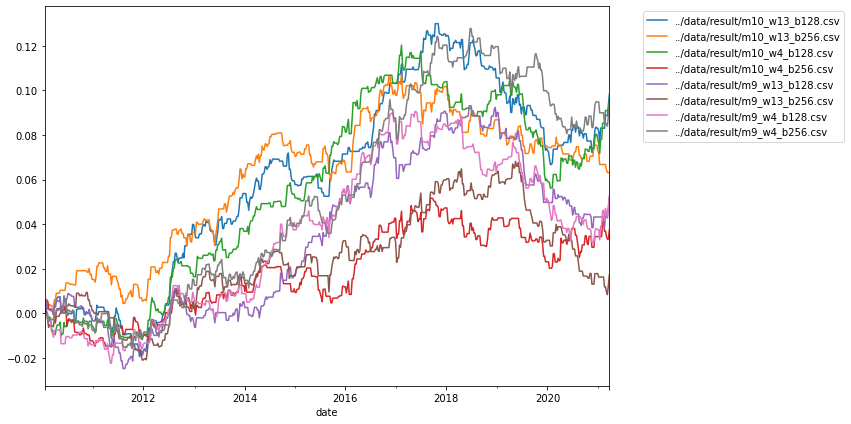

In [81]:
df.add(1).cumprod(axis="index").sub(1).plot(figsize=(12, 6))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()